# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [39]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

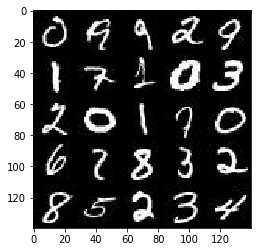

In [40]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

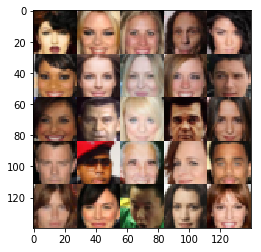

In [41]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [42]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [43]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    return input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [44]:
def discriminator(images, reuse=False, alpha=0.05):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [45]:
def generator(z, out_channel_dim, is_train=True, alpha=0.05):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [49]:
import pickle as pkl
import matplotlib.pyplot as plt

def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        #img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print_every=10
    show_every=100
    figsize=(5,5)
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    samples, losses = [], []
    steps = 0

    # TODO: Build Model
    # Inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr:learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr:learning_rate})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.4456... Generator Loss: 0.0066
Epoch 1/2... Discriminator Loss: 1.7716... Generator Loss: 0.3522
Epoch 1/2... Discriminator Loss: 1.4446... Generator Loss: 1.7560
Epoch 1/2... Discriminator Loss: 2.1447... Generator Loss: 0.3740
Epoch 1/2... Discriminator Loss: 2.6121... Generator Loss: 0.3092
Epoch 1/2... Discriminator Loss: 2.2286... Generator Loss: 0.2341
Epoch 1/2... Discriminator Loss: 1.7477... Generator Loss: 0.3688
Epoch 1/2... Discriminator Loss: 1.7124... Generator Loss: 0.4588
Epoch 1/2... Discriminator Loss: 2.0474... Generator Loss: 0.4475
Epoch 1/2... Discriminator Loss: 1.8328... Generator Loss: 0.4293


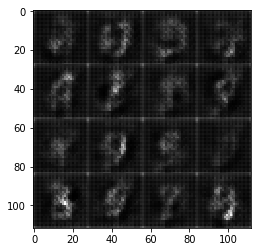

Epoch 1/2... Discriminator Loss: 1.6608... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.8635... Generator Loss: 0.3534
Epoch 1/2... Discriminator Loss: 1.8694... Generator Loss: 0.2932
Epoch 1/2... Discriminator Loss: 1.7934... Generator Loss: 0.2670
Epoch 1/2... Discriminator Loss: 1.6212... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 1.5940... Generator Loss: 0.4823
Epoch 1/2... Discriminator Loss: 1.9730... Generator Loss: 0.2651
Epoch 1/2... Discriminator Loss: 1.6997... Generator Loss: 0.4709
Epoch 1/2... Discriminator Loss: 1.5211... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.6355... Generator Loss: 0.3786


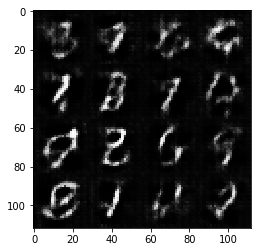

Epoch 1/2... Discriminator Loss: 1.6705... Generator Loss: 0.6758
Epoch 1/2... Discriminator Loss: 1.7393... Generator Loss: 0.3195
Epoch 1/2... Discriminator Loss: 1.8026... Generator Loss: 0.4409
Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 1.7108... Generator Loss: 0.3330
Epoch 1/2... Discriminator Loss: 1.6131... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 1.6075... Generator Loss: 0.4095
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.7284... Generator Loss: 0.3783


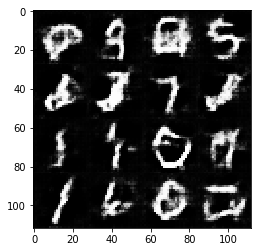

Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 0.4648
Epoch 1/2... Discriminator Loss: 1.5686... Generator Loss: 0.7015
Epoch 1/2... Discriminator Loss: 1.4704... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 1.7927... Generator Loss: 0.2742
Epoch 1/2... Discriminator Loss: 1.5840... Generator Loss: 0.3749
Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 0.6100
Epoch 1/2... Discriminator Loss: 1.7759... Generator Loss: 0.2667
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.6242
Epoch 1/2... Discriminator Loss: 1.5313... Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 0.4076


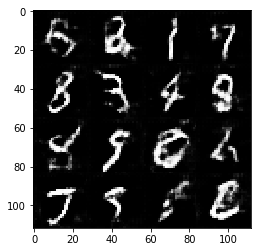

Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.6926... Generator Loss: 1.0644
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.6058
Epoch 1/2... Discriminator Loss: 1.5930... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 0.3136
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.8472... Generator Loss: 0.2880
Epoch 1/2... Discriminator Loss: 1.4146... Generator Loss: 0.6044


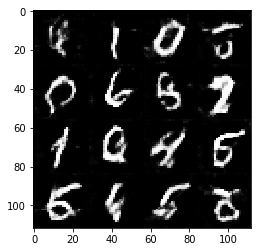

Epoch 1/2... Discriminator Loss: 1.6130... Generator Loss: 0.4085
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 0.6427
Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.4978
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.5225
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 1.7536... Generator Loss: 0.3343
Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.8083... Generator Loss: 0.2577


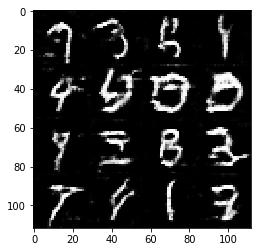

Epoch 1/2... Discriminator Loss: 1.7363... Generator Loss: 0.3335
Epoch 1/2... Discriminator Loss: 1.7618... Generator Loss: 0.4283
Epoch 1/2... Discriminator Loss: 1.6247... Generator Loss: 0.3634
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 1.7075... Generator Loss: 0.3185
Epoch 1/2... Discriminator Loss: 1.5729... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.6320... Generator Loss: 0.5243
Epoch 1/2... Discriminator Loss: 1.6076... Generator Loss: 0.4313
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.4210


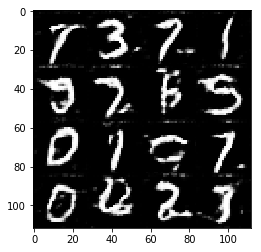

Epoch 1/2... Discriminator Loss: 1.5887... Generator Loss: 0.4196
Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 0.4799
Epoch 1/2... Discriminator Loss: 1.4573... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.5340
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.4483
Epoch 1/2... Discriminator Loss: 1.4461... Generator Loss: 0.4410
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.4797
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 0.5562
Epoch 1/2... Discriminator Loss: 1.8344... Generator Loss: 0.2475


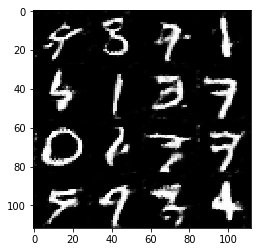

Epoch 1/2... Discriminator Loss: 2.0954... Generator Loss: 0.1807
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.6927
Epoch 1/2... Discriminator Loss: 1.7344... Generator Loss: 0.3423
Epoch 1/2... Discriminator Loss: 1.6726... Generator Loss: 0.3126
Epoch 1/2... Discriminator Loss: 1.5076... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.7836... Generator Loss: 0.2573
Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 1.6423... Generator Loss: 0.3180
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.3194
Epoch 1/2... Discriminator Loss: 2.0653... Generator Loss: 0.1694


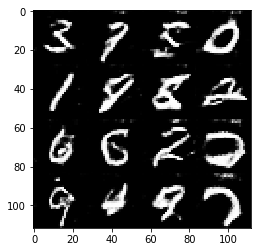

Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.2905
Epoch 1/2... Discriminator Loss: 1.6701... Generator Loss: 0.3077
Epoch 1/2... Discriminator Loss: 1.9566... Generator Loss: 0.2152
Epoch 1/2... Discriminator Loss: 1.9409... Generator Loss: 0.2161
Epoch 1/2... Discriminator Loss: 1.7554... Generator Loss: 0.2829
Epoch 1/2... Discriminator Loss: 1.6135... Generator Loss: 0.3866
Epoch 1/2... Discriminator Loss: 1.8776... Generator Loss: 0.2310
Epoch 1/2... Discriminator Loss: 1.6199... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 1.8383... Generator Loss: 1.2333
Epoch 1/2... Discriminator Loss: 1.5965... Generator Loss: 0.4167


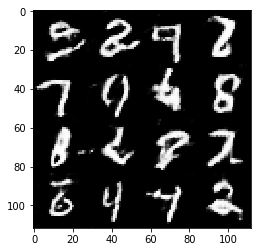

Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.3706
Epoch 1/2... Discriminator Loss: 1.8719... Generator Loss: 0.2176
Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 1.8657... Generator Loss: 0.2473
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 0.4216
Epoch 1/2... Discriminator Loss: 1.6470... Generator Loss: 0.3073
Epoch 1/2... Discriminator Loss: 1.6392... Generator Loss: 0.3997


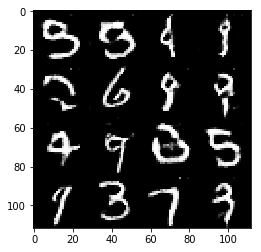

Epoch 1/2... Discriminator Loss: 1.6639... Generator Loss: 0.5108
Epoch 1/2... Discriminator Loss: 1.4444... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.6261... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 1.5954... Generator Loss: 0.4331
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.3567
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 1.2581
Epoch 1/2... Discriminator Loss: 1.6044... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.4975
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.5338


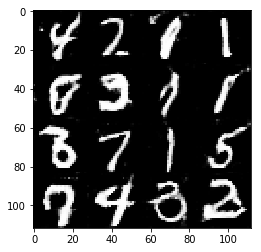

Epoch 1/2... Discriminator Loss: 1.9007... Generator Loss: 0.2212
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.4580
Epoch 1/2... Discriminator Loss: 1.5822... Generator Loss: 0.3849
Epoch 1/2... Discriminator Loss: 1.3658... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 1.8987... Generator Loss: 0.2467
Epoch 1/2... Discriminator Loss: 1.8717... Generator Loss: 0.2230
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.5445
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.3359
Epoch 1/2... Discriminator Loss: 1.9772... Generator Loss: 0.2002
Epoch 1/2... Discriminator Loss: 1.2451... Generator Loss: 0.8572


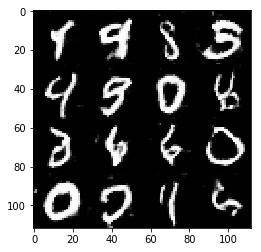

Epoch 1/2... Discriminator Loss: 1.6598... Generator Loss: 0.2723
Epoch 1/2... Discriminator Loss: 1.6550... Generator Loss: 0.3195
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.5089... Generator Loss: 0.4816
Epoch 1/2... Discriminator Loss: 1.7141... Generator Loss: 0.4007
Epoch 1/2... Discriminator Loss: 1.6391... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 0.4290
Epoch 1/2... Discriminator Loss: 2.0242... Generator Loss: 0.1892
Epoch 1/2... Discriminator Loss: 1.9549... Generator Loss: 0.2082


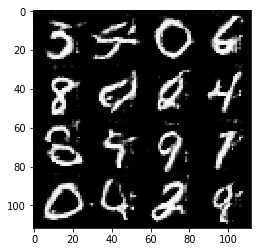

Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.4794
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.5115
Epoch 1/2... Discriminator Loss: 1.6564... Generator Loss: 0.3731
Epoch 1/2... Discriminator Loss: 1.6909... Generator Loss: 0.2631
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.4336
Epoch 1/2... Discriminator Loss: 1.4716... Generator Loss: 0.5454
Epoch 1/2... Discriminator Loss: 1.6547... Generator Loss: 1.1481
Epoch 1/2... Discriminator Loss: 1.4536... Generator Loss: 0.8889
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 0.5024


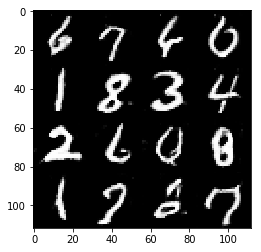

Epoch 1/2... Discriminator Loss: 1.7855... Generator Loss: 0.2533
Epoch 1/2... Discriminator Loss: 1.7508... Generator Loss: 0.2763
Epoch 1/2... Discriminator Loss: 1.4911... Generator Loss: 0.4073
Epoch 1/2... Discriminator Loss: 2.4142... Generator Loss: 0.1151
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.3434
Epoch 1/2... Discriminator Loss: 1.6722... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 1.3944... Generator Loss: 0.4778
Epoch 1/2... Discriminator Loss: 1.5454... Generator Loss: 0.3906
Epoch 1/2... Discriminator Loss: 1.9237... Generator Loss: 0.2141
Epoch 1/2... Discriminator Loss: 1.8404... Generator Loss: 0.2559


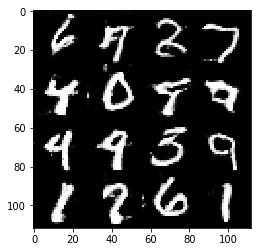

Epoch 1/2... Discriminator Loss: 1.5844... Generator Loss: 0.3698
Epoch 1/2... Discriminator Loss: 1.7978... Generator Loss: 0.2441
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.3990
Epoch 1/2... Discriminator Loss: 1.4898... Generator Loss: 0.4240
Epoch 1/2... Discriminator Loss: 1.2733... Generator Loss: 0.5173
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 1.1011
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.4586
Epoch 1/2... Discriminator Loss: 1.5522... Generator Loss: 0.4816
Epoch 1/2... Discriminator Loss: 1.8933... Generator Loss: 0.2437
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.6155


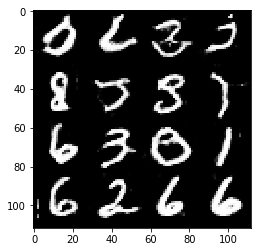

Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 1.6549
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 0.4536
Epoch 1/2... Discriminator Loss: 1.5741... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 0.2631
Epoch 1/2... Discriminator Loss: 1.6151... Generator Loss: 0.3325
Epoch 1/2... Discriminator Loss: 1.6581... Generator Loss: 0.2870
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.5635
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 2.1778... Generator Loss: 0.2082


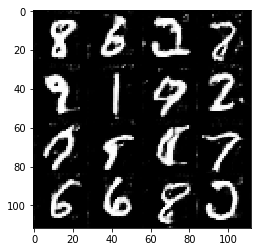

Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 1.0165
Epoch 1/2... Discriminator Loss: 1.4481... Generator Loss: 0.5072
Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.4637
Epoch 1/2... Discriminator Loss: 2.3974... Generator Loss: 0.1187
Epoch 1/2... Discriminator Loss: 2.0010... Generator Loss: 0.2002
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 0.9787
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.4046
Epoch 2/2... Discriminator Loss: 1.4424... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 2.3908... Generator Loss: 0.1286
Epoch 2/2... Discriminator Loss: 1.6646... Generator Loss: 0.2977


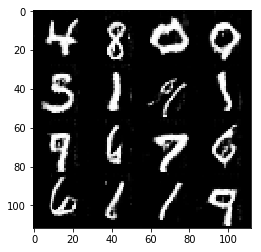

Epoch 2/2... Discriminator Loss: 1.5592... Generator Loss: 0.3089
Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.5242
Epoch 2/2... Discriminator Loss: 1.5374... Generator Loss: 0.4359
Epoch 2/2... Discriminator Loss: 2.0223... Generator Loss: 0.2121
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.3944
Epoch 2/2... Discriminator Loss: 1.5993... Generator Loss: 0.3384
Epoch 2/2... Discriminator Loss: 1.8569... Generator Loss: 0.2362
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.6729
Epoch 2/2... Discriminator Loss: 1.2869... Generator Loss: 0.4778
Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 0.7917


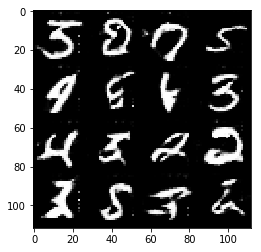

Epoch 2/2... Discriminator Loss: 1.8316... Generator Loss: 0.2481
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 1.5840... Generator Loss: 0.3040
Epoch 2/2... Discriminator Loss: 2.0134... Generator Loss: 0.1945
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.5411
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 1.6287... Generator Loss: 0.3762
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.4333
Epoch 2/2... Discriminator Loss: 1.2797... Generator Loss: 0.4790
Epoch 2/2... Discriminator Loss: 2.0273... Generator Loss: 0.1876


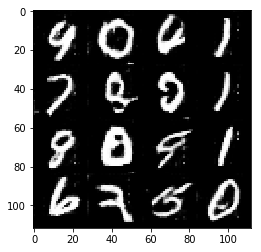

Epoch 2/2... Discriminator Loss: 1.2476... Generator Loss: 0.8975
Epoch 2/2... Discriminator Loss: 1.4822... Generator Loss: 0.4298
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 1.2638
Epoch 2/2... Discriminator Loss: 1.7347... Generator Loss: 0.2913
Epoch 2/2... Discriminator Loss: 1.4993... Generator Loss: 0.4389
Epoch 2/2... Discriminator Loss: 2.2136... Generator Loss: 0.1591
Epoch 2/2... Discriminator Loss: 2.0383... Generator Loss: 0.2488
Epoch 2/2... Discriminator Loss: 1.2827... Generator Loss: 0.6180
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.6364
Epoch 2/2... Discriminator Loss: 2.2951... Generator Loss: 0.1481


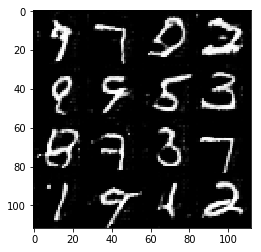

Epoch 2/2... Discriminator Loss: 1.7728... Generator Loss: 0.2847
Epoch 2/2... Discriminator Loss: 1.4936... Generator Loss: 0.3829
Epoch 2/2... Discriminator Loss: 1.7473... Generator Loss: 0.3006
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.8463
Epoch 2/2... Discriminator Loss: 1.6326... Generator Loss: 0.3620
Epoch 2/2... Discriminator Loss: 1.1589... Generator Loss: 0.6663
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 1.0534
Epoch 2/2... Discriminator Loss: 2.3090... Generator Loss: 0.1705
Epoch 2/2... Discriminator Loss: 1.7486... Generator Loss: 0.3080


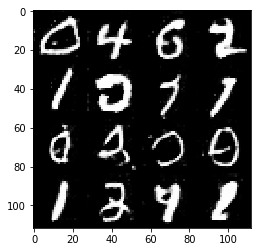

Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.6775... Generator Loss: 0.3367
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 1.2634
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.4181
Epoch 2/2... Discriminator Loss: 2.0009... Generator Loss: 0.2059
Epoch 2/2... Discriminator Loss: 1.9631... Generator Loss: 0.2392
Epoch 2/2... Discriminator Loss: 0.7529... Generator Loss: 1.1721
Epoch 2/2... Discriminator Loss: 1.1733... Generator Loss: 0.5681


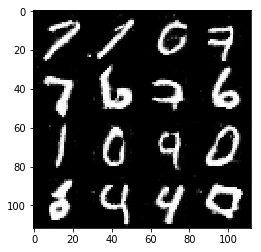

Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.6028
Epoch 2/2... Discriminator Loss: 1.0356... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 1.3334... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.5652... Generator Loss: 0.3038
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.4590
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 1.8658... Generator Loss: 0.2222
Epoch 2/2... Discriminator Loss: 1.3718... Generator Loss: 0.7942
Epoch 2/2... Discriminator Loss: 1.7206... Generator Loss: 0.2733
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.5767


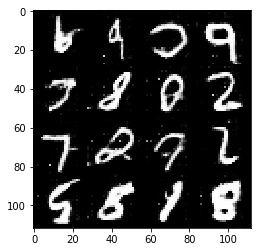

Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.5712
Epoch 2/2... Discriminator Loss: 1.9798... Generator Loss: 0.2484
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 0.3609
Epoch 2/2... Discriminator Loss: 2.3083... Generator Loss: 0.1432
Epoch 2/2... Discriminator Loss: 1.5945... Generator Loss: 0.3487
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.8077... Generator Loss: 0.2327
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 3.1368... Generator Loss: 0.0545
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.5530


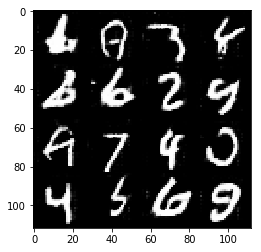

Epoch 2/2... Discriminator Loss: 1.4749... Generator Loss: 0.3240
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 1.8637
Epoch 2/2... Discriminator Loss: 1.8061... Generator Loss: 0.3258
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.4737
Epoch 2/2... Discriminator Loss: 1.0959... Generator Loss: 0.5751
Epoch 2/2... Discriminator Loss: 1.3834... Generator Loss: 0.4222
Epoch 2/2... Discriminator Loss: 1.8427... Generator Loss: 0.2720
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 0.8248
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.4707


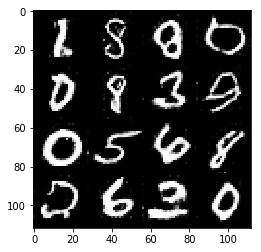

Epoch 2/2... Discriminator Loss: 2.5773... Generator Loss: 0.1539
Epoch 2/2... Discriminator Loss: 1.6009... Generator Loss: 0.3379
Epoch 2/2... Discriminator Loss: 1.6576... Generator Loss: 0.3898
Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 0.6769
Epoch 2/2... Discriminator Loss: 1.2311... Generator Loss: 0.5396
Epoch 2/2... Discriminator Loss: 1.6216... Generator Loss: 0.3063
Epoch 2/2... Discriminator Loss: 1.6748... Generator Loss: 0.3926
Epoch 2/2... Discriminator Loss: 1.5143... Generator Loss: 0.4316
Epoch 2/2... Discriminator Loss: 1.4642... Generator Loss: 0.4727
Epoch 2/2... Discriminator Loss: 1.7037... Generator Loss: 0.3377


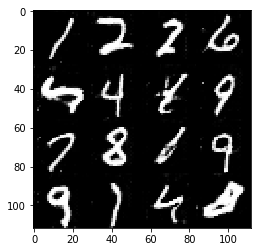

Epoch 2/2... Discriminator Loss: 1.9143... Generator Loss: 0.2932
Epoch 2/2... Discriminator Loss: 1.4860... Generator Loss: 0.3418
Epoch 2/2... Discriminator Loss: 1.6952... Generator Loss: 0.2818
Epoch 2/2... Discriminator Loss: 1.4920... Generator Loss: 0.4332
Epoch 2/2... Discriminator Loss: 1.6820... Generator Loss: 0.3329
Epoch 2/2... Discriminator Loss: 1.5594... Generator Loss: 0.3269
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.4418
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.4524
Epoch 2/2... Discriminator Loss: 1.8056... Generator Loss: 0.3321
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.4370


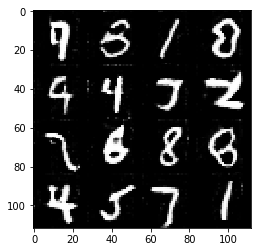

Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.5340
Epoch 2/2... Discriminator Loss: 1.5849... Generator Loss: 0.3211
Epoch 2/2... Discriminator Loss: 2.3027... Generator Loss: 0.1728
Epoch 2/2... Discriminator Loss: 1.8914... Generator Loss: 0.2304
Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.7490... Generator Loss: 0.3416
Epoch 2/2... Discriminator Loss: 1.7313... Generator Loss: 0.8302
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.5386
Epoch 2/2... Discriminator Loss: 1.6670... Generator Loss: 1.0102
Epoch 2/2... Discriminator Loss: 1.9641... Generator Loss: 0.2365


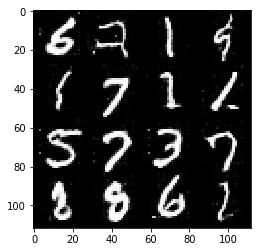

Epoch 2/2... Discriminator Loss: 1.4963... Generator Loss: 0.4325
Epoch 2/2... Discriminator Loss: 1.2936... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 2.2354... Generator Loss: 0.1773
Epoch 2/2... Discriminator Loss: 1.9662... Generator Loss: 0.2145
Epoch 2/2... Discriminator Loss: 1.8830... Generator Loss: 0.2270
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 1.5164
Epoch 2/2... Discriminator Loss: 1.6084... Generator Loss: 0.3194
Epoch 2/2... Discriminator Loss: 1.5287... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.5536... Generator Loss: 0.3941
Epoch 2/2... Discriminator Loss: 2.3594... Generator Loss: 0.1635


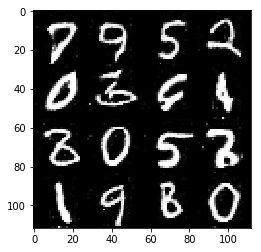

Epoch 2/2... Discriminator Loss: 2.0277... Generator Loss: 0.2250
Epoch 2/2... Discriminator Loss: 0.9107... Generator Loss: 0.8988
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.7878... Generator Loss: 0.3519
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 1.2745... Generator Loss: 0.4798
Epoch 2/2... Discriminator Loss: 1.7026... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 2.2992... Generator Loss: 0.1672
Epoch 2/2... Discriminator Loss: 1.7103... Generator Loss: 0.3126
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.6019


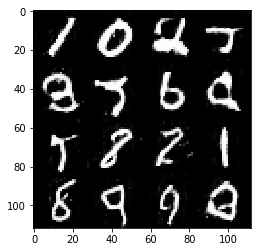

Epoch 2/2... Discriminator Loss: 2.0682... Generator Loss: 0.2068
Epoch 2/2... Discriminator Loss: 1.1157... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 2.2915... Generator Loss: 0.1787
Epoch 2/2... Discriminator Loss: 2.1725... Generator Loss: 1.8221
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.4534
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 1.1392
Epoch 2/2... Discriminator Loss: 1.6389... Generator Loss: 0.3305
Epoch 2/2... Discriminator Loss: 2.1647... Generator Loss: 0.2104
Epoch 2/2... Discriminator Loss: 1.8841... Generator Loss: 0.2684
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.4776


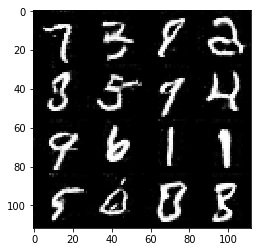

Epoch 2/2... Discriminator Loss: 1.7268... Generator Loss: 0.3142
Epoch 2/2... Discriminator Loss: 2.4144... Generator Loss: 0.2259
Epoch 2/2... Discriminator Loss: 0.9910... Generator Loss: 0.9164
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 1.3040... Generator Loss: 0.5026
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.4562
Epoch 2/2... Discriminator Loss: 1.7997... Generator Loss: 0.2714
Epoch 2/2... Discriminator Loss: 2.1996... Generator Loss: 0.1896
Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.3771... Generator Loss: 0.5044


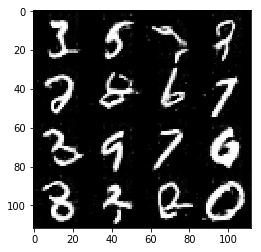

Epoch 2/2... Discriminator Loss: 1.5431... Generator Loss: 0.3893
Epoch 2/2... Discriminator Loss: 2.1201... Generator Loss: 0.2235
Epoch 2/2... Discriminator Loss: 0.5360... Generator Loss: 1.5735
Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 0.9667
Epoch 2/2... Discriminator Loss: 2.8706... Generator Loss: 0.0967
Epoch 2/2... Discriminator Loss: 1.6484... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 1.4435
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.3738
Epoch 2/2... Discriminator Loss: 1.7652... Generator Loss: 0.2523


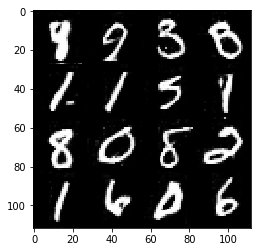

Epoch 2/2... Discriminator Loss: 2.4127... Generator Loss: 0.1433
Epoch 2/2... Discriminator Loss: 1.7153... Generator Loss: 0.3016
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.5151
Epoch 2/2... Discriminator Loss: 2.0471... Generator Loss: 0.2309
Epoch 2/2... Discriminator Loss: 1.7322... Generator Loss: 0.3168
Epoch 2/2... Discriminator Loss: 1.5165... Generator Loss: 0.4046
Epoch 2/2... Discriminator Loss: 1.7649... Generator Loss: 0.2620
Epoch 2/2... Discriminator Loss: 1.6884... Generator Loss: 0.3187
Epoch 2/2... Discriminator Loss: 2.1148... Generator Loss: 0.1914
Epoch 2/2... Discriminator Loss: 2.0735... Generator Loss: 0.2011


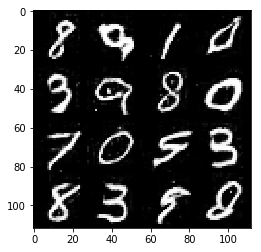

Epoch 2/2... Discriminator Loss: 1.6300... Generator Loss: 0.3142
Epoch 2/2... Discriminator Loss: 1.6521... Generator Loss: 0.3261
Epoch 2/2... Discriminator Loss: 1.5787... Generator Loss: 0.3297
Epoch 2/2... Discriminator Loss: 1.9784... Generator Loss: 0.2633
Epoch 2/2... Discriminator Loss: 1.0937... Generator Loss: 0.7192
Epoch 2/2... Discriminator Loss: 1.4194... Generator Loss: 0.5721
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 1.7465... Generator Loss: 0.4023
Epoch 2/2... Discriminator Loss: 1.9381... Generator Loss: 0.2914
Epoch 2/2... Discriminator Loss: 1.3952... Generator Loss: 1.8879


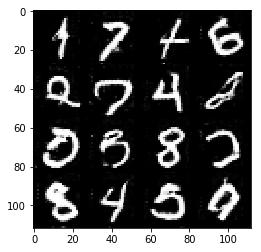

Epoch 2/2... Discriminator Loss: 1.5460... Generator Loss: 0.4292
Epoch 2/2... Discriminator Loss: 1.4429... Generator Loss: 0.4361
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.9994
Epoch 2/2... Discriminator Loss: 1.8486... Generator Loss: 0.3239
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 0.8958


In [51]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.4938... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 3.5473... Generator Loss: 0.0830
Epoch 1/1... Discriminator Loss: 3.0078... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 1.6509... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 2.6186... Generator Loss: 0.2010
Epoch 1/1... Discriminator Loss: 1.7547... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.7390... Generator Loss: 0.3992
Epoch 1/1... Discriminator Loss: 1.8720... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.8399... Generator Loss: 0.3821
Epoch 1/1... Discriminator Loss: 1.8107... Generator Loss: 0.4408


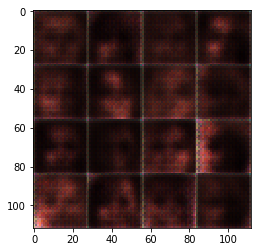

Epoch 1/1... Discriminator Loss: 1.7259... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 2.2586... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.7955... Generator Loss: 0.4247
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.4508
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.4763
Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.7338... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.5061


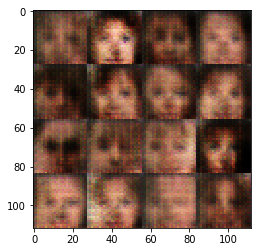

Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.8874... Generator Loss: 0.4931
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.7740... Generator Loss: 0.4706
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.8134... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.6449... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.5736


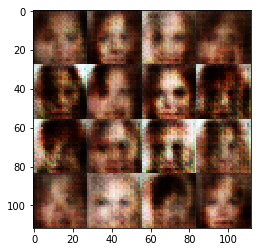

Epoch 1/1... Discriminator Loss: 1.6688... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.6491... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.5680


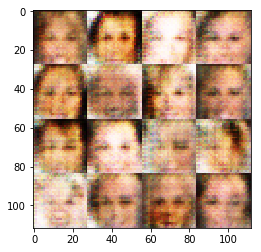

Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.6323... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.6837... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.6801... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.6970... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.5870


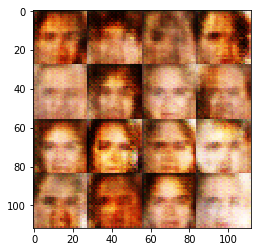

Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.5642
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6266


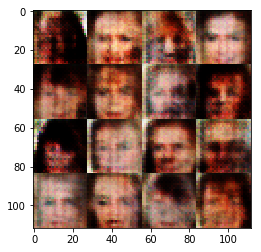

Epoch 1/1... Discriminator Loss: 1.6518... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.6805... Generator Loss: 0.4409
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.5644


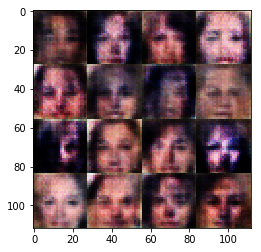

Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.5730
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.5268
Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.4767
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6081


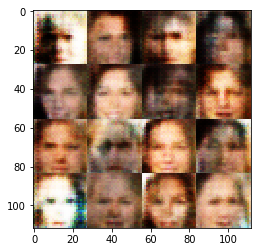

Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.6349


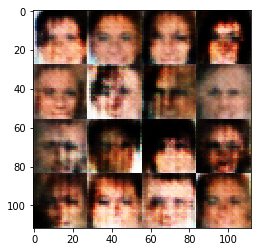

Epoch 1/1... Discriminator Loss: 1.6151... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.5829... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.6908... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.5173


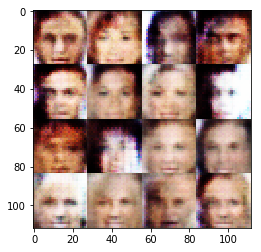

Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.5660... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6951


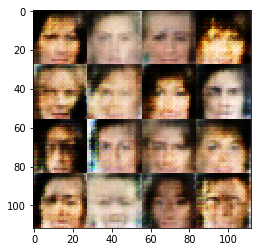

Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.6335... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.5663... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.5394... Generator Loss: 0.5551


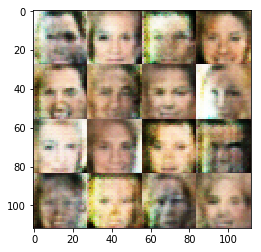

Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6508


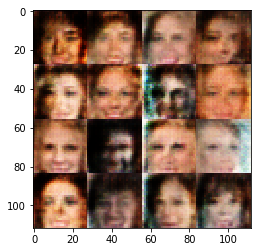

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6531


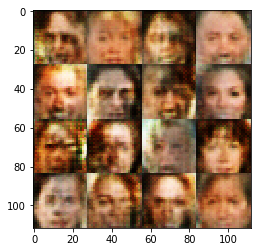

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6086


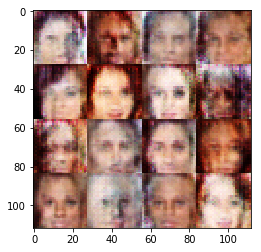

Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6749


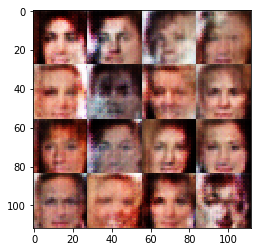

Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.5785


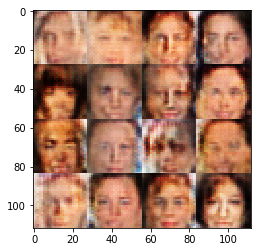

Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6136


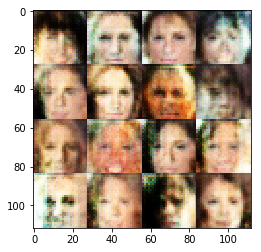

Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6232


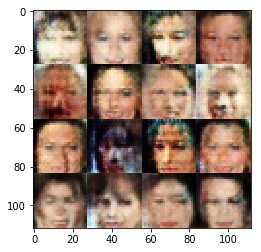

Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6101
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.5125


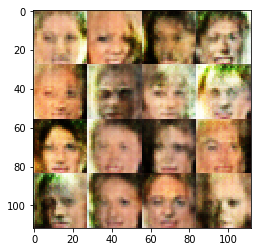

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.5594


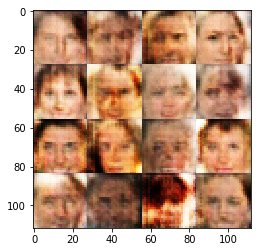

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.5524... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6035


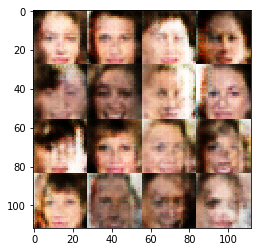

Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6601


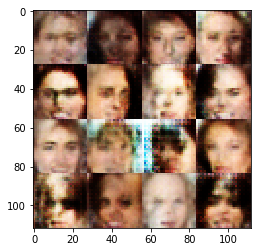

Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5868


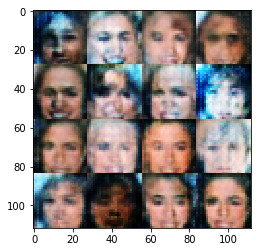

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6035


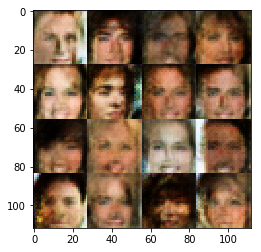

Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4999... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6605


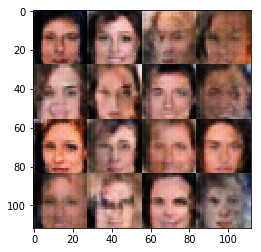

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6321


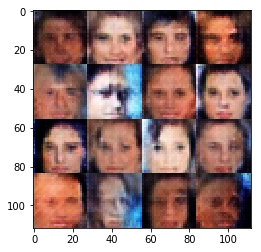

Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6454


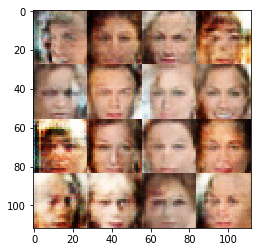

Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5337


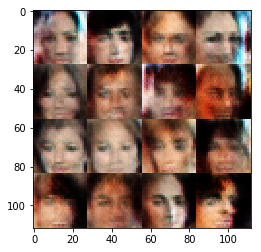

Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.5665


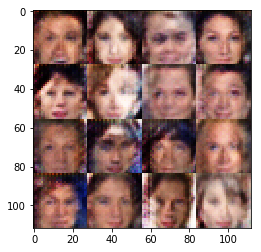

Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7292


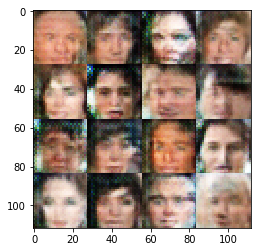

Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.4703


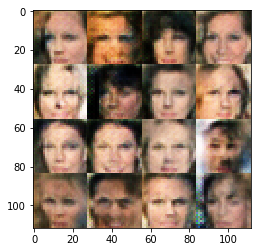

Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6179


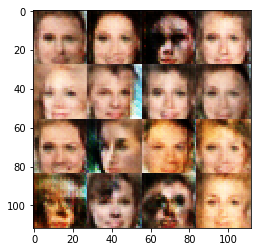

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7052


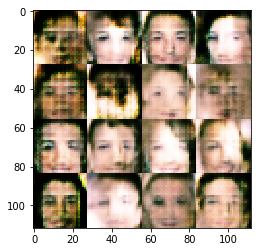

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6509


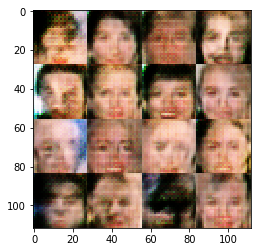

Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6713


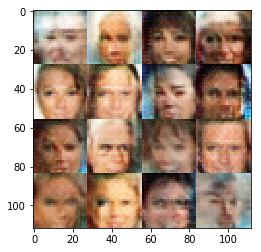

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.5786
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.4619
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6318


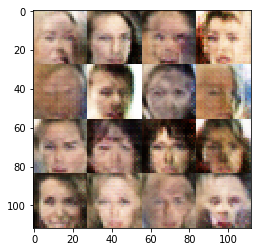

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.5277
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7915


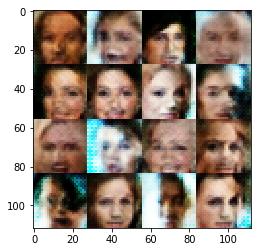

Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.6696


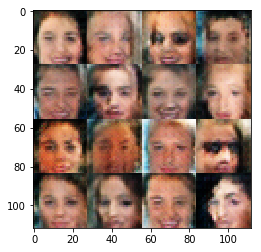

Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.5733
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5959


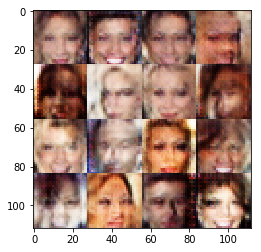

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.6162... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.5450


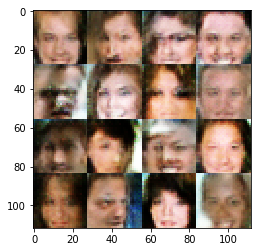

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6324


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.